In [1]:
import polars as pl
import os
from pathlib import Path

In [2]:
import Utils.constants
from Utils.constants import FOLDER
from Utils.constants import N_LANES, N_SPEEDS, N_TIME_LIMIT, N_DIRECTIONS, N_SPEED_DEVIATION, N_LANE_DEVIATION, N_TIME_LIMIT
from Utils.constants import MAX_COST_VALUE
from Utils.constants import index_to_speed,direction_to_lane_change
print(f"N_LANES: {N_LANES} N_SPEEDS:{N_SPEEDS} N_DIRECTIONS:{N_DIRECTIONS}")
print(f"State space {N_LANES*N_SPEEDS*N_DIRECTIONS} N_SPEED_DEVIATION:{N_SPEED_DEVIATION} N_LANE_DEVIATION:{N_LANE_DEVIATION}")

N_LANES: 15 N_SPEEDS:20 N_DIRECTIONS:3
State space 900 N_SPEED_DEVIATION:2 N_LANE_DEVIATION:1


In [3]:
# FOLDER = r"C:\\Users\\johan\\OneDrive\\Documents\\Python\\Python\\SilverStone"
# N_LANES = 11

In [4]:
path = Path(FOLDER + r"\\TrackData.csv")
df = pl.read_csv(path)
df.describe()

statistic,x_m,y_m,w_tr_right_m,w_tr_left_m
str,f64,f64,f64,f64
"""count""",1178.0,1178.0,1178.0,1178.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",499.955727,422.160986,6.91325,6.903748
"""std""",296.582725,513.272093,0.502209,0.46919
"""min""",-59.443563,-531.787771,5.415,5.753
"""25%""",223.900974,-2.673913,6.662,6.608
"""50%""",528.367204,422.172969,6.882,6.866
"""75%""",771.00166,882.154398,7.094,7.094
"""max""",960.872993,1192.3602,8.851,8.99


In [5]:
#Create and add the lanes
ldf = df.lazy()
aldf = ldf.with_columns([
    (pl.col("x_m").shift(-1) - pl.col("x_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("x_dir"),
    (pl.col("y_m").shift(-1) - pl.col("y_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("y_dir"),
    (pl.col("w_tr_left_m") + pl.col("w_tr_right_m")).alias("width")
]).with_columns([
    (pl.col("x_dir")*pl.col("x_dir") + pl.col("y_dir")*pl.col("y_dir")).sqrt().alias("norm_dir")
]).with_columns([
    (pl.col("x_dir")/pl.col("norm_dir")).alias("x_udir"),
    (pl.col("y_dir")/pl.col("norm_dir")).alias("y_udir")
])

lane_factors = [-0.5 + i / (N_LANES - 1) for i in range(N_LANES)]
print(lane_factors)
aldf = aldf.with_columns(
        [(pl.col("x_m") - pl.lit(f) * pl.col("width") * pl.col("y_udir")).alias(f"x_lane{i}") for i, f in enumerate(lane_factors)] +
        [(pl.col("y_m") + pl.lit(f) * pl.col("width") * pl.col("x_udir")).alias(f"y_lane{i}") for i, f in enumerate(lane_factors)]
    )

def get_curvature():
    x_udir1 = pl.col("x_udir").shift(-1).fill_null(strategy="forward")
    x_udir0 = pl.col("x_udir")
    y_udir1 = pl.col("y_udir").shift(-1).fill_null(strategy="forward")
    y_udir0 = pl.col("y_udir")
    return ((y_udir1 - y_udir0).pow(2) + (x_udir1 - x_udir0).pow(2)).sqrt().alias(f"dir_delta")
aldf = aldf.with_columns(get_curvature())

lanesdfd = aldf.collect()
lanesdfd.describe()
lanesdfd

[-0.5, -0.4285714285714286, -0.35714285714285715, -0.2857142857142857, -0.2142857142857143, -0.14285714285714285, -0.07142857142857145, 0.0, 0.0714285714285714, 0.1428571428571429, 0.2142857142857143, 0.2857142857142857, 0.3571428571428571, 0.4285714285714286, 0.5]


x_m,y_m,w_tr_right_m,w_tr_left_m,x_dir,y_dir,width,norm_dir,x_udir,y_udir,x_lane0,x_lane1,x_lane2,x_lane3,x_lane4,x_lane5,x_lane6,x_lane7,x_lane8,x_lane9,x_lane10,x_lane11,x_lane12,x_lane13,x_lane14,y_lane0,y_lane1,y_lane2,y_lane3,y_lane4,y_lane5,y_lane6,y_lane7,y_lane8,y_lane9,y_lane10,y_lane11,y_lane12,y_lane13,y_lane14,dir_delta
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.439354,-0.495322,6.556,6.536,5.862596,8.10221,13.092,10.000792,0.586213,0.810157,8.742641,7.985028,7.227416,6.469804,5.712191,4.954579,4.196966,3.439354,2.681742,1.924129,1.166517,0.408904,-0.348708,-1.10632,-1.863933,-4.332673,-3.78448,-3.236287,-2.688094,-2.139901,-1.591708,-1.043515,-0.495322,0.052871,0.601064,1.149257,1.69745,2.245643,2.793836,3.342029,0.0
6.370784,3.555763,6.558,6.537,5.862596,8.10221,13.095,10.000792,0.586213,0.810157,11.675286,10.9175,10.159714,9.401928,8.644142,7.886356,7.12857,6.370784,5.612998,4.855212,4.097426,3.33964,2.581854,1.824068,1.066282,-0.282468,0.265851,0.81417,1.362488,1.910807,2.459126,3.007444,3.555763,4.104082,4.6524,5.200719,5.749038,6.297356,6.845675,7.393994,0.000046
9.30195,7.606888,6.56,6.538,5.862087,8.102292,13.098,10.00056,0.586176,0.810184,14.607844,13.849859,13.091874,12.333889,11.575905,10.81792,10.059935,9.30195,8.543965,7.78598,7.027995,6.270011,5.512026,4.754041,3.996056,3.768022,4.316432,4.864841,5.41325,5.96166,6.510069,7.058479,7.606888,8.155297,8.703707,9.252116,9.800526,10.348935,10.897344,11.445754,0.000043
12.232871,11.658055,6.562,6.539,5.861618,8.10238,13.101,10.000356,0.586141,0.810209,17.540146,16.781964,16.023782,15.2656,14.507417,13.749235,12.991053,12.232871,11.474689,10.716507,9.958325,9.200142,8.44196,7.683778,6.925596,7.818539,8.367041,8.915544,9.464046,10.012548,10.56105,11.109553,11.658055,12.206557,12.75506,13.303562,13.852064,14.400566,14.949069,15.497571,0.00004
15.163568,15.709268,6.564,6.54,5.861189,8.102473,13.104,10.00018,0.586108,0.810233,20.472213,19.713835,18.955457,18.197079,17.438701,16.680324,15.921946,15.163568,14.40519,13.646812,12.888435,12.130057,11.371679,10.613301,9.854923,11.869086,12.417684,12.966281,13.514878,14.063476,14.612073,15.160671,15.709268,16.257865,16.806463,17.35506,17.903658,18.452255,19.000852,19.54945,0.000037
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-11.222438,-20.750233,6.535,6.559,5.866447,8.101822,13.094,10.002736,0.586484,0.809961,-5.919626,-6.67717,-7.434715,-8.19226,-8.949804,-9.707349,-10.464893,-11.222438,-11.979983,-12.737527,-13.495072,-14.252616,-15.010161,-15.767706,-16.52525,-24.589945,-24.041415,-23.492885,-22.944354,-22.395824,-21.847294,-21.298763,-20.750233,-20.201703,-19.653172,-19.104642,-18.556112,-18.007581,-17.459051,-16.910521,0.000061
-8.289395,-16.699311,6.54,6.553,5.865724,8.101872,13.093,10.002352,0.586434,0.809997,-2.986752,-3.744272,-4.501793,-5.259313,-6.016834,-6.774354,-7.531875,-8.289395,-9.046915,-9.804436,-10.561956,-11.319477,-12.076997,-12.834518,-13.592038,-20.538404,-19.989962,-19.44152,-18.893079,-18.344637,-17.796195,-17.247753,-16.699311,-16.150869,-15.602427,-15.053985,-14.505543,-13.957102,-13.40866,-12.860218,0.00006
-5.356714,-12.648361,6.544,6.548,5.865019,8.10193,13.092,10.001986,0.586385,0.810032,-0.054244,-0.811739,-1.569235,-2.326731,-3.084227,-3.841722,-4.599218,-5.356714,-6.11421,-6.871706,-7.629201,-8.386697,-9.144193,-9.901689,-10.659184,-16.48684,-15.938486,-15.390132,-14.841778,-14.293424,-13.745069,-13.196715,-12.648361,-12.100007,-11.551653,-11.003298,-10.454944,-9.90659,-9.358236,-8.809882,0.000057


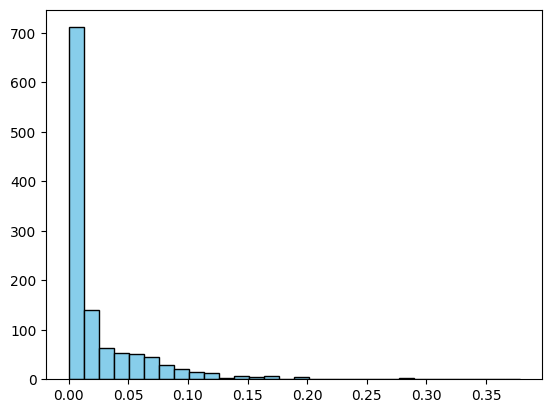

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting a basic histogram
plt.hist(list(lanesdfd["dir_delta"]), bins=30, color='skyblue', edgecolor='black')
plt.show()

In [ ]:
#attempt to thin the frame


lanesdfd = lanesdfd.lazy().with_columns(
        [(pl.col("x_udir").shift(-1).fill_null(strategy="forward") - pl.lit(f) * pl.col("width") * pl.col("y_udir")).alias(f"x_lane{i}") for i, f in enumerate(lane_factors)] +
        [(pl.col("y_m") + pl.lit(f) * pl.col("width") * pl.col("x_udir")).alias(f"y_lane{i}") for i, f in enumerate(lane_factors)]
    )

lanesdfd = aldf.collect()
lanesdfd.describe()
lanesdfd

: 

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

for i in range(N_LANES):
    fig.add_trace(go.Scatter(
        x = lanesdfd["x_lane" + str(i)].to_numpy(),
        y = lanesdfd["y_lane" + str(i)].to_numpy(),
        mode = "markers",
        marker  = dict(size=3),
        name = "lane " + str(i)
    ))

fig.update_layout(
    width=1200,
    height=1000,
    title="Track Lanes",
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

fig.show()

: 

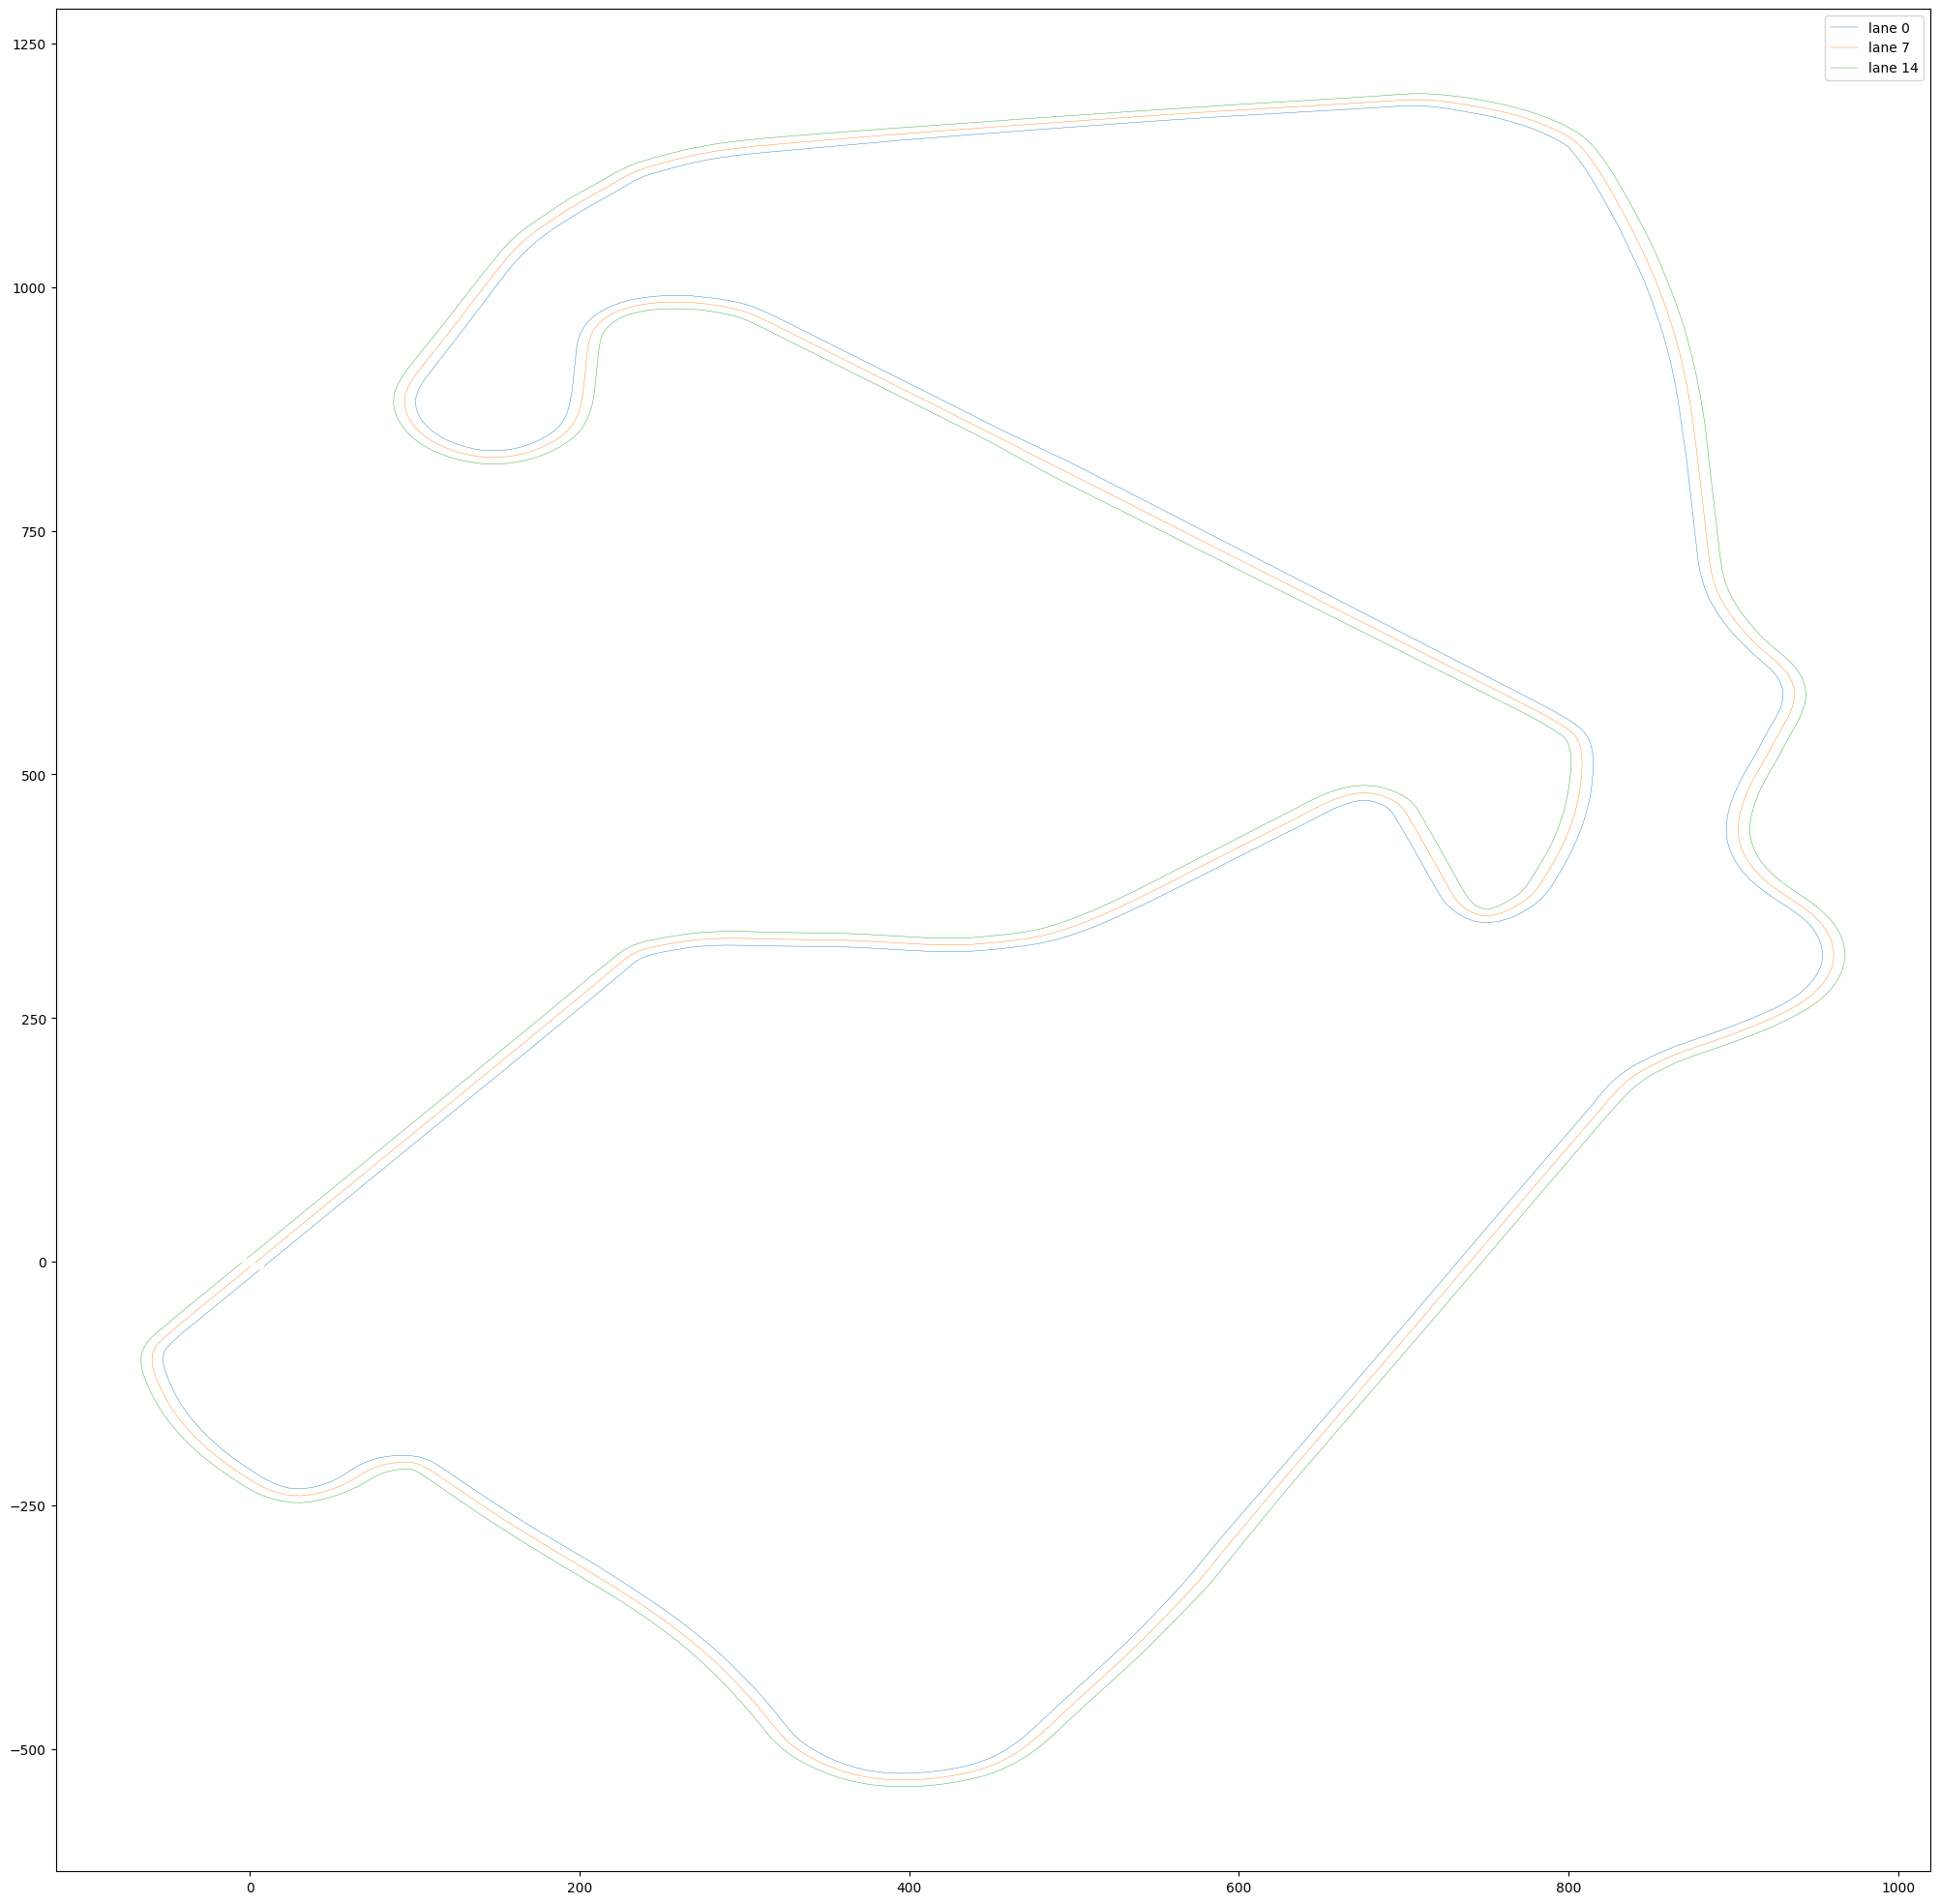

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))

lanes = [0,int(N_LANES/2), N_LANES-1]
for l in lanes:

    plt.plot(lanesdfd["x_lane"+str(l)].to_numpy(),
             lanesdfd["y_lane"+str(l)].to_numpy(),
             linewidth=0.3,
             label="lane "+str(l))

plt.legend()
plt.show()

In [8]:
path = Path(FOLDER + f"\\TrackLanes_{N_LANES}.parquet")
lanesdfd.write_parquet(path)

In [9]:
print(len(lanesdfd))
lanesdfd2 = (
    lanesdfd
    .with_row_index("idx")  # adds 0,1,2,... as 'idx'
    .filter(
        # keep all rows above threshold
        (pl.col("dir_delta") >= 0.015)
        |
        # for rows below threshold, keep only every 3rd one
        (
            (pl.col("dir_delta") < 0.015) & (pl.col("dir_delta") > 0.005) & ((pl.col("idx") % 3) != 0) | ((pl.col("dir_delta") < 0.005) & ((pl.col("idx") % 3) == 0))
        )
    )
    .drop("idx")  # optional: clean up
)
print(len(lanesdfd2))
path = Path(FOLDER + f"\\TrackLanes_{N_LANES}.parquet")
lanesdfd.write_parquet(path)

1178
740


In [10]:
import plotly.graph_objects as go
fig = go.Figure()

for i in range(N_LANES):
    fig.add_trace(go.Scatter(
        x = lanesdfd2["x_lane" + str(i)].to_numpy(),
        y = lanesdfd2["y_lane" + str(i)].to_numpy(),
        mode = "markers",
        marker  = dict(size=3),
        name = "lane " + str(i)
    ))

fig.update_layout(
    width=1200,
    height=1000,
    title="Track Lanes",
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

fig.show()

: 

: 